3.99384141282
20.0308404192


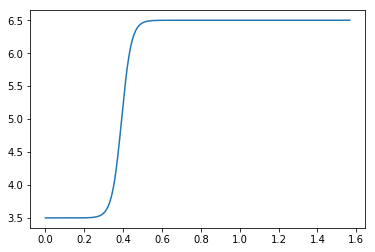

In [1]:
from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt

n_dim = 2
r0, r1, dr = [None]*3
S = 0.9
n_t = None
save_every = 10

r_c = None
omega = 2.0*np.pi
s_pml = None
d_pml = None

L_0 = 2.0*np.pi/omega

eps_r_0 = np.array([3.5, 3.5, 3.5])
eps_r_1 = np.array([6.5, 1.0, 1.0])
eps_r_max = max(np.max(np.abs(eps_r_0)), np.max(np.abs(eps_r_1)))
L_g = L_0/np.sqrt(eps_r_max)

def smoothswitch(t, f0=1, f1=2, alpha=1, t0=0):
    return f0 + 0.5*(1.0 + np.tanh(alpha*(t-t0)))*(f1 - f0)
alpha = 20.0
t0 = L_g*1

eps_r = [lambda r, t: smoothswitch(t, eps_r_0[0], eps_r_1[0], alpha, t0),
         lambda r, t: smoothswitch(t, eps_r_0[1], eps_r_1[1], alpha, t0),
         lambda r, t: smoothswitch(t, eps_r_0[2], eps_r_1[2], alpha, t0)]

if n_dim==3:
    r0 = np.array([0.0, 0.0, 0.0])
    r1 = np.array([1.0, 1.0, 1.0])*10.0*L_g
    dr = np.array([1.0, 1.0, 1.0])*L_g/40
    S /= np.sqrt(3)
    n_t = 2000
    
    r_c = (r0+r1)/2.0    
    d_pml = np.array([0.2, 0.2, 0.2])*L_g
    s_pml = np.array([1.0+1.0j, 1.0+1.0j, 1.0+1.0j])/d_pml*3.0
elif n_dim==2:
    r0 = np.array([0.0, 0.0])
    r1 = np.array([1.0, 1.0])*2.0*L_g
    dr = np.array([1.0, 1.0])*L_g/50
    S /= np.sqrt(2)
    n_t = 800
    
    r_c = (r0+r1)/2.0    
    d_pml = np.array([1.0, 1.0])*L_g
    s_pml = np.array([1.0+1.0j, 1.0+1.0j])/d_pml*3.0

elif n_dim==1:
    assert False
    
dt = S*dr[0]/np.sqrt(eps_r_max)
d_v = np.prod(dr)

print((n_t*dt)/t0)
i_change = t0/dt/save_every
print(i_change)

_t_samples_ = np.linspace(0.0, n_t*dt, n_t)
plt.plot(_t_samples_, eps_r[0](0,_t_samples_))
plt.show()



In [2]:

fdtd = FDTDSimulator()

fdtd.SetSimulationBox(r0, r1, dr, dt)
fdtd.save_every = save_every 

d_x_ = np.zeros(n_dim)
d_x_[0] = (r1[0]-r0[0])
d_x_pml = np.zeros(n_dim)
d_x_pml[0] = d_pml[0]

t0_j = t0/2
T_j = t0_j/4
f_t = lambda t: np.exp(-(t - t0_j)**2/T_j**2)*np.sin(omega*(t-t0_j)) 

## J
r_j = r_c
je_mag = 1.0/dr[0]
src_dir = 'y'
je_args = None
je_type = FVTypes.JePoint
je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}

fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

eps_args = {'r0':r0, 'r1':r1, 'mag_in':eps_r, 'mag_out':[1, 1, 1]}
fdtd.AddMaterial({'type':FVTypes.EpsDiagSTvarBox, 'name':'eps', 'args':eps_args})


pml_args = {'d_pml':d_pml, 's_pml':s_pml}
fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

set_eps_out = False

r_out = r_c + np.ones(n_dim)*L_0/100

if n_dim==3:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'x', 'O_dir':'x', 'name':'E'}})
elif n_dim<=2:
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'x', 'O_dir':None, 'name':'Ex'}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'y', 'O_dir':None, 'name':'Ey'}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'Ez'}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'x', 'O_dir':'x', 'name':'Ex-slice'}})
    fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_out, 'args':{'A':'E', 'A_dir':'y', 'O_dir':'x', 'name':'Ey-slice'}})

        
fdtd.StepFields(n_t)
n_saved = fdtd.n_saved
    


simulation time: 0:1


max(e_max): 0.159769162108
(100, 99) (100, 99)


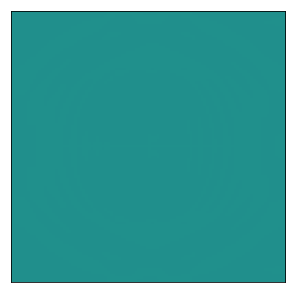

In [3]:
import matplotlib.pyplot as plt

r_E, E_out_list = fdtd.GetOutputs('Ey')
x_E, y_E, z_E = [None]*3
if n_dim==3:
    x_E, y_E, z_E = r_E
elif n_dim==2:
    x_E, y_E = r_E
elif n_dim==1:
    x_E = r_E[0]
e_max = [np.max(np.abs(e)) for e in E_out_list]
print('max(e_max):', max(e_max))
e_max = max(e_max)
    

print(x_E.shape, E_out_list[0].shape)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["figure.figsize"] = (5, 5)

if n_dim==2:
    fig = plt.imshow(E_out_list[-1].T, vmin=-e_max/10, vmax=e_max/10)
    ax = plt.gca()
    ax.set_adjustable('box-forced')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.show()


In [4]:
%pylab tk

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

# Set up formatting for the movie files
#Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
#writer = Writer(fps=15, metadata=dict(artist='Me'))
#writer = animation.FFMpegWriter()

plt_field = 'E'
save_anim = False
file_format = 'gif'   ## 'gif' / 'mp4'

logscale=True
log_0 = np.log(e_max)-20

use_subplots = False

font = {'family' : 'serif', 'weight' : 'normal', 'size' : 14}
matplotlib.rc('font', **font)

fig = None
if n_dim>=2:
    def animate_E(i):
        plt.clf()
        #fig = plt.pcolor(y_E, z_E, E_out_list[i])
        if not logscale:
            #fig = plt.imshow(np.abs(E_out_list[i]).T, vmin=0.0, vmax=e_max/100)
            fig = plt.imshow(E_out_list[i].T, origin='lower', vmin=-e_max/10, vmax=e_max/10, cmap='rainbow', \
                             aspect='auto')
        else:
            E_log = np.log(np.abs(E_out_list[i]))
            E_log = (E_log>=log_0)*E_log + (E_log<log_0)*(log_0)
            fig = plt.imshow(E_log.T, origin='lower', vmin=log_0, vmax=np.log(e_max), cmap='rainbow', \
                             aspect='auto')

        #CB = plt.colorbar(fig, shrink=0.8, extend='both')
        ax = plt.gca()
        ax.set_adjustable('box-forced')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        plt.colorbar()
        if i>i_change:
            plt.title('*', fontsize=20, color='r')
        if i%10==0:
            print("{}/{}".format(i, n_saved), end=" ")
        return fig

    fig = plt.figure()
    axes = plt.gca()
    anim = None
    if plt_field=='E':
        anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1, repeat=False)
    else:
        raise ValuError()

    if save_anim:
        if file_format=='gif':
            anim.save('other/e-2d.gif', writer="imagemagick", fps=15, dpi=200)
        elif file_format=='mp4':
            anim.save('other/e-2d.mp4', writer="mencoder", fps=15, dpi=200)
    plt.show()

    

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply


0/80 0/80 10/80 20/80 30/80 40/80 50/80 60/80 70/80 

(60, 10000)


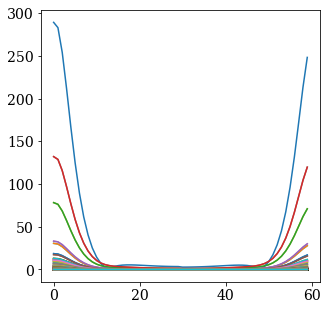

max :  289.097574642
0 5000
289.097574642


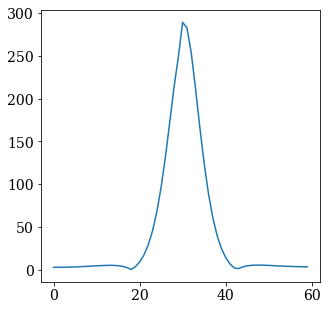

In [21]:

r_E, E_out_list = fdtd.GetOutputs('Ey-slice')
x_E, y_E, z_E = [None]*3
if n_dim==3:
    x_E, y_E, z_E = r_E
elif n_dim==2:
    x_E, y_E = r_E

E_out = np.array(E_out_list).T
print(E_out.shape)

E_f = np.fft.fftshift(np.fft.fft(E_out))
plt.plot(np.abs(E_f))
plt.show()

print('max : ', np.max(np.abs(E_f)))
E_f_abs = np.abs(E_f)
ind_max1 = np.argmax(E_f_abs, axis=1)
ind_max0 = np.argmax(E_f_abs[np.arange(E_f_abs.shape[0]),ind_max1])
ind_max1 = ind_max1[ind_max0]
print(ind_max0, ind_max1)
print(E_f_abs[(ind_max0, ind_max1)])

E_w_r = np.fft.ifftshift(E_f[:,ind_max1])
    
#plt.plot(np.abs(E_f[:,-1]))
plt.plot(np.abs(E_w_r))
plt.show()
    